# Notebook Versions

- Version 1
   * EDA and Baseline Modeling 1.0
 


# Importing Libraries

In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc

import holidays

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from ydf import RandomForestLearner, GradientBoostedTreesLearner
import ydf

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

CPU times: user 3.11 s, sys: 623 ms, total: 3.73 s
Wall time: 5.95 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s5e1/train.csv', index_col=0)
train['date']= pd.to_datetime(train['date'])
train = train.dropna().reset_index(drop=True)
# train['num_sold'] = train['num_sold'].fillna(0)

test = pd.read_csv('../input/playground-series-s5e1/test.csv', index_col=0)
test['date'] = pd.to_datetime(test['date'])

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (221259, 5)
The dimension of the test dataset is: (98550, 4)
CPU times: user 319 ms, sys: 61.5 ms, total: 381 ms
Wall time: 531 ms


In [3]:
train.head()

,date,country,store,product,num_sold
0,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
1,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
2,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
3,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
4,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0


In [4]:
test.head()

,date,country,store,product
id,,,,
230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
230131,2017-01-01,Canada,Discount Stickers,Kaggle
230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
230133,2017-01-01,Canada,Discount Stickers,Kerneler
230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Train ---

date        0.0
country     0.0
store       0.0
product     0.0
num_sold    0.0
dtype: float64


--- Test ---

date       0.0
country    0.0
store      0.0
product    0.0
dtype: float64


From the above, we see there are some missing values in `num_sold`.

# Data Exploration

First, we start by visualizing `num_sold` by `product` and `country`.

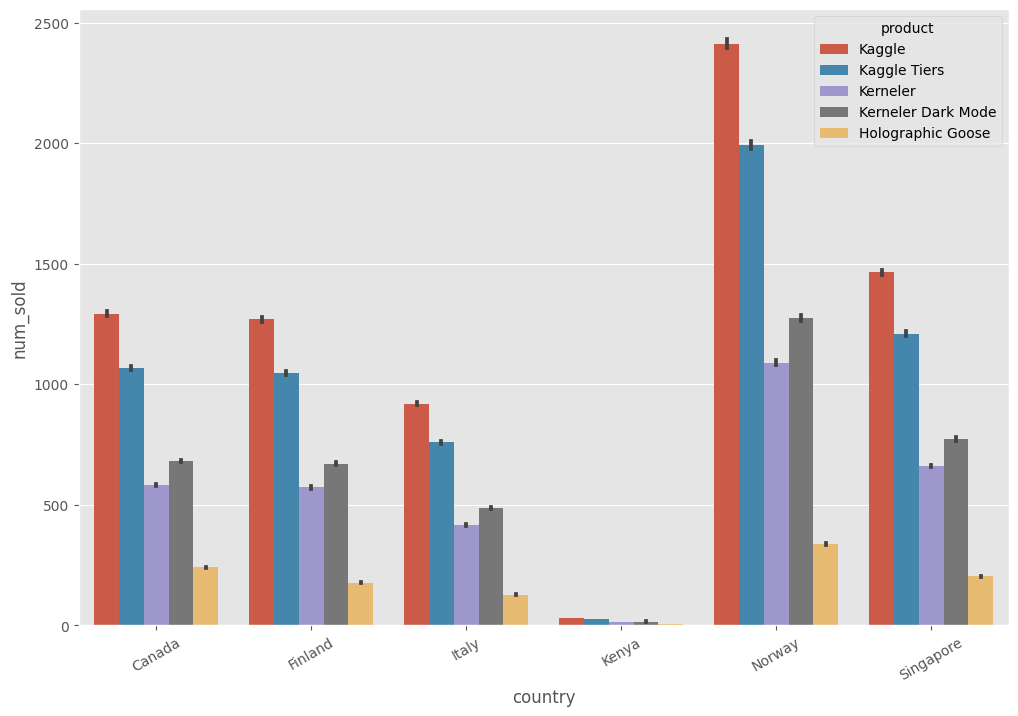

In [6]:
plt.figure(figsize = (12, 8))

ax = sns.barplot(data=train, x='country', y='num_sold', hue='product')
plt.xticks(rotation=30);

From the above chart, these are a couple of observations:

- The `Kaggle` sticker is the most sold product across all countries.
- The `Holographic Goose` sticker is the least sold product across all countries.
- `Norway` is the country with the most sales.
- `Kenya` is the country with the least sales.

Next we visualize the total number of sticker sales as time-series for each of the countries.

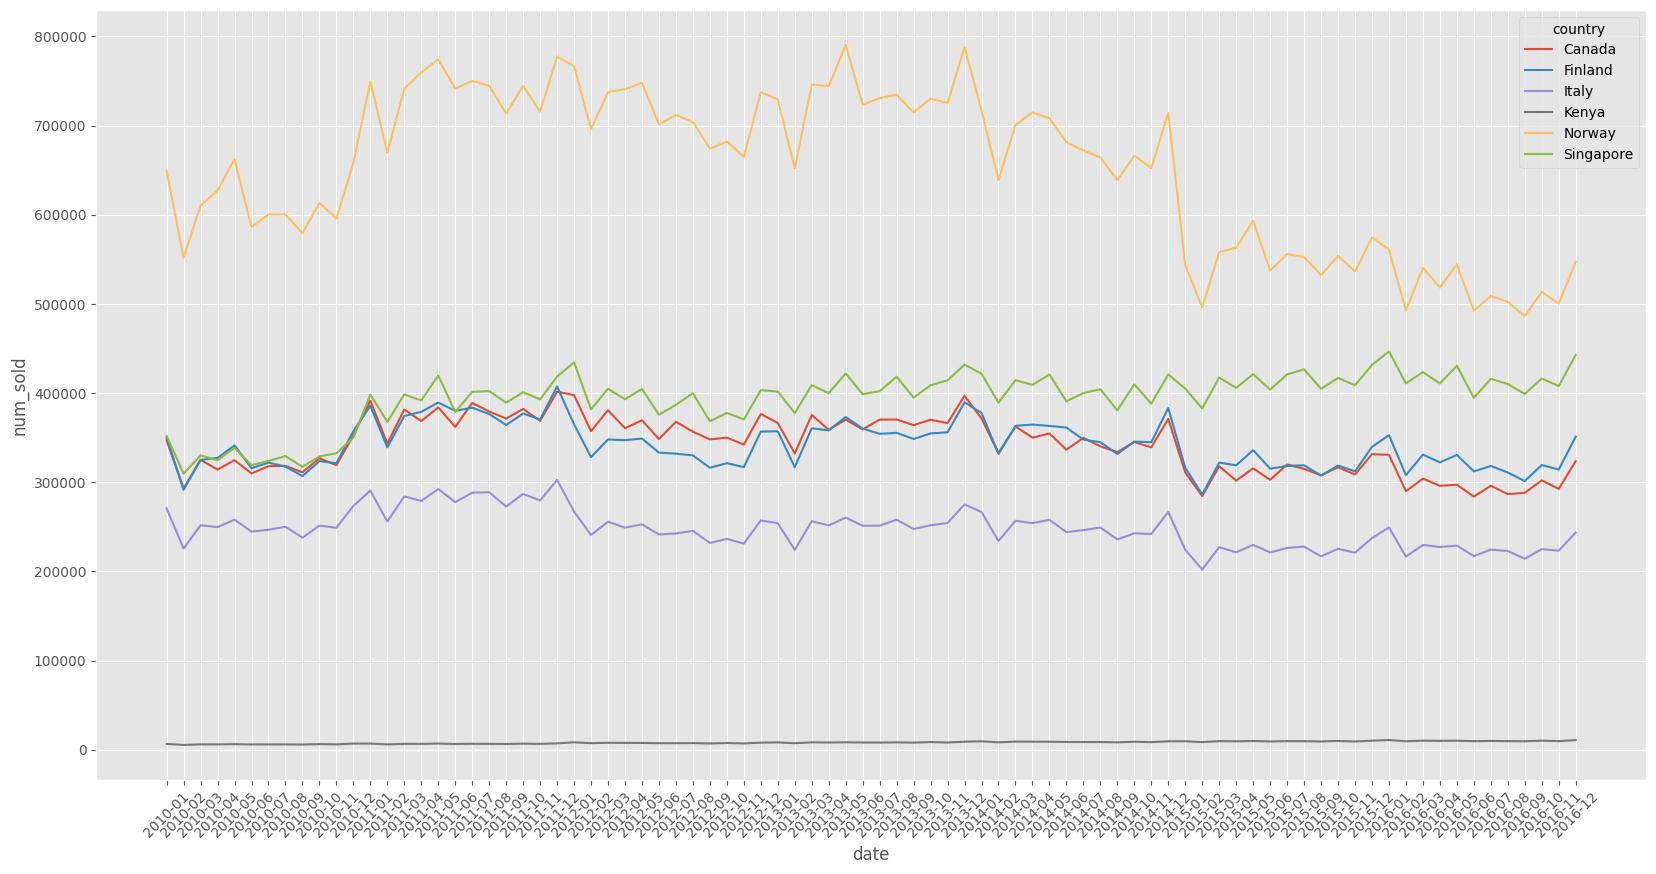

In [7]:
plt.figure(figsize = (20, 10))

ax = sns.lineplot(data = train.groupby([train.date.dt.strftime('%Y-%m'), train.country])['num_sold'].sum().reset_index(),
                  x='date',
                  y='num_sold',
                  hue='country')
plt.xticks(rotation = 45);

Based on the above chart, it seems that number of sticker sold are highly correlated across all countries.

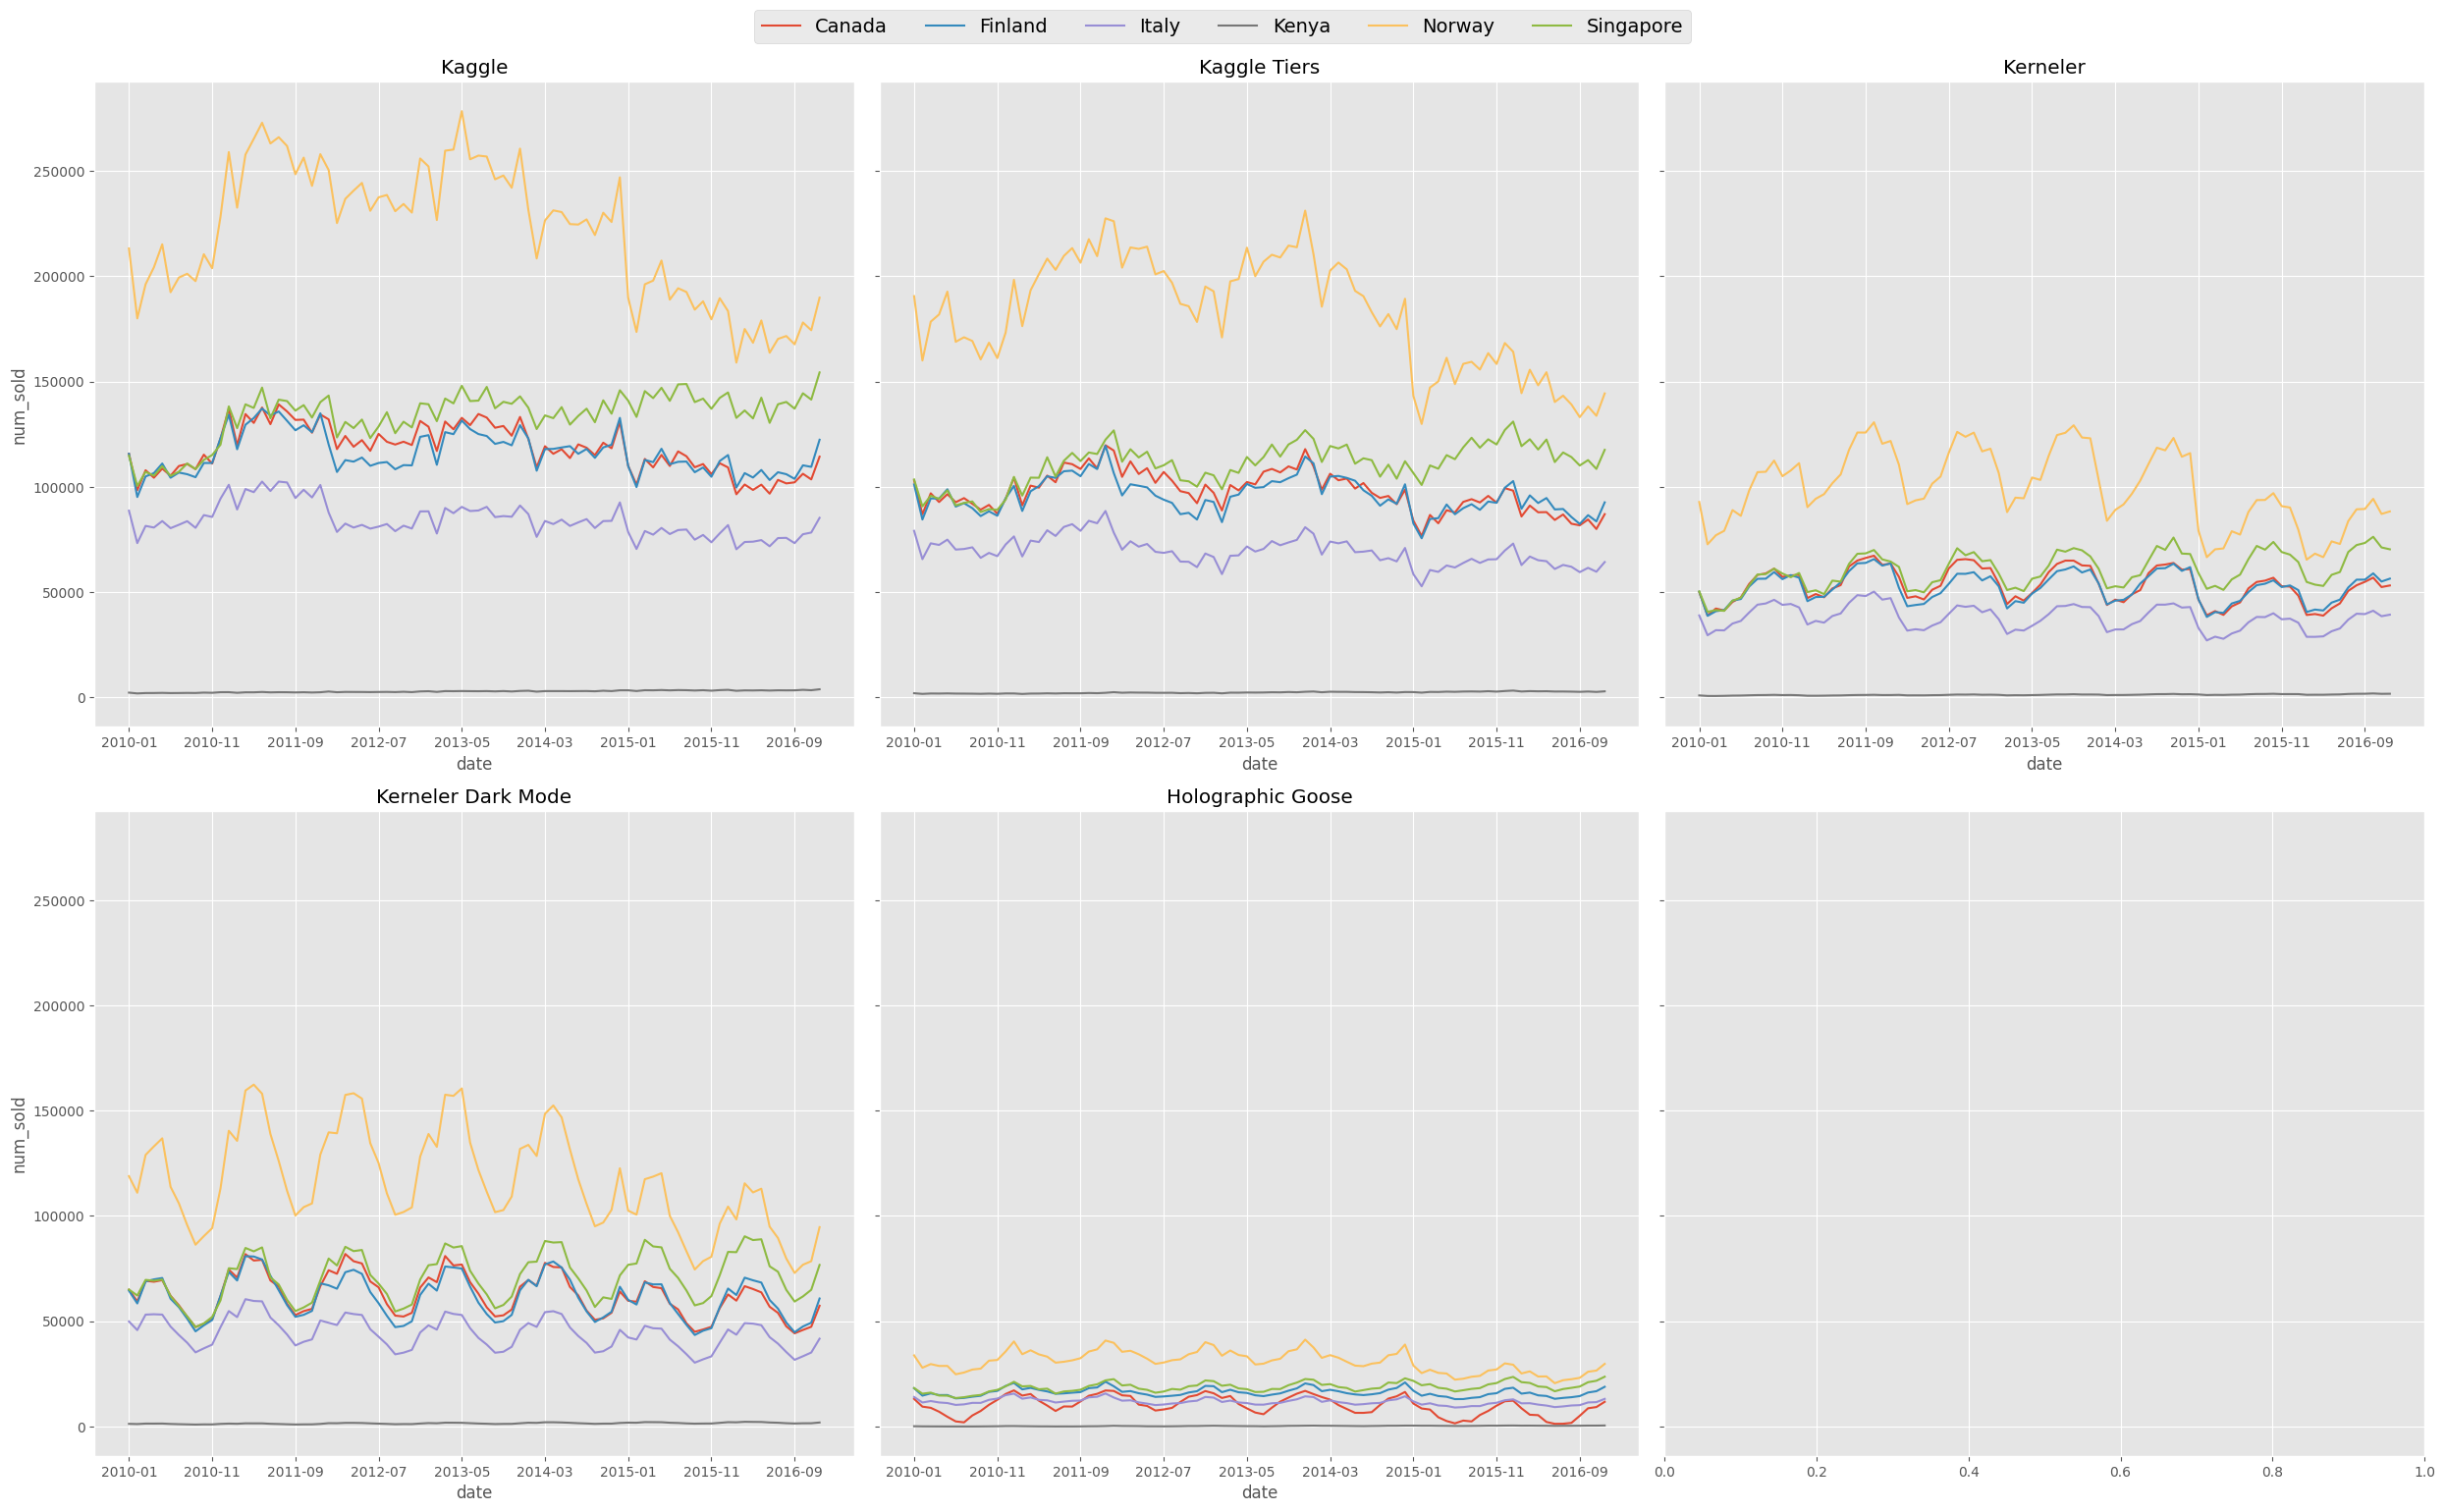

In [8]:
fig, ax = plt.subplots(2, 3, figsize = (25, 15), sharey = True)
ax = ax.flatten()
hue_order = train.country.unique()

for i, product in enumerate(train['product'].unique()):
    df = train[train['product'] == product]
    sns.lineplot(data = df.groupby([df.date.dt.strftime('%Y-%m'), df.country])['num_sold'].sum().reset_index(),
                 x = 'date',
                 y = 'num_sold',
                 hue = 'country',
                 ax = ax[i],
                 hue_order = hue_order
    )
    ax[i].set_title(product)
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].legend().remove()
    
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 1.03), fontsize = 14, ncol = 6)
plt.tight_layout()

From the above chart, these are a couple of observations:

- There is a seasonality in the number of sticker sold.
- The seasonality is different across the products.

# Baseline Modeling 1.0

First, we engineer some features from `date`.

In [9]:
%%time
def get_holidays(df):
    years_list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

    holiday_FI = holidays.CountryHoliday('FI', years = years_list)
    holiday_CA = holidays.CountryHoliday('CA', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_KE = holidays.CountryHoliday('KE', years = years_list)
    holiday_NO = holidays.CountryHoliday('NO', years = years_list)
    holiday_SI = holidays.CountryHoliday('SG', years = years_list)

    holiday_dict = holiday_FI.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_KE)
    holiday_dict.update(holiday_NO)
    holiday_dict.update(holiday_SI)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    df.drop(columns='holiday_name', axis=1, inplace=True)
    
    return df


def feature_engineer(df):
    
    new_df = df.copy()
    new_df['year'] = new_df['date'].dt.year
    new_df['year_sin'] = np.sin(new_df['year'] * (2 * np.pi))
    new_df['year_cos'] = np.cos(new_df['year'] * (2 * np.pi))

    new_df['month'] = new_df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df['day'] = new_df['date'].dt.day
    new_df['day_sin'] = np.sin(new_df['day'] * (2 * np.pi / 365))
    new_df['day_cos'] = np.cos(new_df['day'] * (2 * np.pi / 365))
    
    new_df['day_of_week'] = new_df['date'].dt.dayofweek
    new_df['day_of_week'] = new_df['day_of_week'].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    # new_df = pd.get_dummies(new_df, columns=['day_of_week'], drop_first=True, dtype=int)
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 124, 125, 126, 127, 140, 141, 
                       167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 
                       203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 
                       312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    
    new_df['important_date'] = np.where(np.isin(new_df['day'], important_dates), 1, 0)
        
    return new_df.drop(columns=['date', 'month', 'day'], axis=1)

train = get_holidays(train)
train = feature_engineer(train)

test = get_holidays(test)
test = feature_engineer(test)

CPU times: user 330 ms, sys: 48.8 ms, total: 379 ms
Wall time: 450 ms


Then, we define the input and target features as follows.

In [10]:
%%time
for cols in ['country', 'store', 'product']:
    train[cols] = train[cols].astype('category')
    test[cols] = test[cols].astype('category')
    
X = train.drop(columns=['num_sold'], axis=1)
y = np.log1p(train['num_sold'])

CPU times: user 55.8 ms, sys: 99 µs, total: 55.9 ms
Wall time: 55.6 ms


First, we consider a time series cross-validation strategy. 

In [11]:
%%time
year_list = train['year'].unique().tolist()
lgb_params = {'objective': 'mape',
              'learning_rate': 0.08581671058380945,
              'n_estimators': 1000,
              'max_depth': 8,
              'reg_alpha': 7.4137713950946855,
              'reg_lambda': 0.03320034177331515,
              'num_leaves': 97,
              'colsample_bytree': 0.7353362488668553,
              'verbose': -1,
              'n_jobs': -1,
              'device': 'gpu'}

scores = []
for idx, yr in enumerate(year_list[:-4]):
    
    train_year = year_list[:idx+2]
    test_year = year_list[(idx+2):(idx+5)]

    X_train = X[np.isin(X.year, train_year)]
    X_train = X_train.drop(columns=['year'], axis=1)

    X_test = X[np.isin(X.year, test_year)]
    X_test = X_test.drop(columns=['year'], axis=1)

    y_train = y[np.isin(X.year, train_year)]
    y_test = y[np.isin(X.year, test_year)]

    lgb_md = LGBMRegressor(**lgb_params).fit(X_train, y_train)
    lgb_pred = lgb_md.predict(X_test)
    
    mape_oof = mean_absolute_percentage_error(y_test, lgb_pred)
    scores.append(mape_oof)
    
    print('Fold', idx, '==> LGBM oof MAPE is ==>', mape_oof)

ts_avg_score = np.mean(scores)
ts_std_score = np.std(scores)
print("\n")
print(f"The average oof MAPE of the LGBM model is {ts_avg_score}")
print(f"The std oof MAPE of the LGBM model is {ts_std_score}")

Fold 0 ==> LGBM oof MAPE is ==> 0.02538255370801055
Fold 1 ==> LGBM oof MAPE is ==> 0.02707410300338798
Fold 2 ==> LGBM oof MAPE is ==> 0.027527942336791154


The average oof MAPE of the LGBM model is 0.026661533016063225
The std oof MAPE of the LGBM model is 0.0009231589202140431
CPU times: user 1min 6s, sys: 1.02 s, total: 1min 7s
Wall time: 20 s


Next, we consider a `GroupKFold` strategy to train the `LGBMRegressor` model.

In [12]:
%%time
lgb_params = {'objective': 'mape',
              'learning_rate': 0.05385753736096176,
              'n_estimators': 1000,
              'max_depth': 14,
              'reg_alpha': 9.383236949308191,
              'reg_lambda': 0.30428754302668776,
              'num_leaves': 50,
              'colsample_bytree': 0.7809567901629245,
              'verbose': -1,
              'n_jobs': -1,
              'device': 'gpu'}

scores = []
skf = GroupKFold(n_splits=7)
for i, (trn_idx, test_idx) in enumerate(skf.split(X, groups=X.year)):
    
    X_train, X_test = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[trn_idx], y.iloc[test_idx]

    X_train = X_train.drop(columns=['year'], axis=1)
    X_test = X_test.drop(columns=['year'], axis=1)

    lgb_md = LGBMRegressor(**lgb_params).fit(X_train, y_train)
    lgb_pred = lgb_md.predict(X_test)

    mape_oof = mean_absolute_percentage_error(y_test, lgb_pred)
    scores.append(mape_oof)
    
    print('Group', i, '==> LGBM oof MAPE is ==>', mape_oof)

gk_avg_score = np.mean(scores)
gk_std_score = np.std(scores)
print("\n")
print(f"The average oof MAPE of the LGBM model is {gk_avg_score}")
print(f"The std oof MAPE of the LGBM model is {gk_std_score}")

Group 0 ==> LGBM oof MAPE is ==> 0.02419293968074488
Group 1 ==> LGBM oof MAPE is ==> 0.030572477230090198
Group 2 ==> LGBM oof MAPE is ==> 0.03044505822902363
Group 3 ==> LGBM oof MAPE is ==> 0.02790043207847059
Group 4 ==> LGBM oof MAPE is ==> 0.028064057557666937
Group 5 ==> LGBM oof MAPE is ==> 0.02489151131443813
Group 6 ==> LGBM oof MAPE is ==> 0.0360203694658062


The average oof MAPE of the LGBM model is 0.028869549365177223
The std oof MAPE of the LGBM model is 0.0036994186772234786
CPU times: user 9min 21s, sys: 3.87 s, total: 9min 25s
Wall time: 2min 40s


Finally, we consider a `KFold` strategy to train the `LGBMRegressor` model.

In [13]:
%%time
lgb_params = {'learning_rate': 0.07049928250360378,
              'n_estimators': 1000,
              'max_depth': 12,
              'reg_alpha': 0.01260164540047986,
              'reg_lambda': 5.6849501092111305,
              'num_leaves': 82,
              'colsample_bytree': 0.689643373301433,
              'verbose': -1,
              'n_jobs': -1,
              'device': 'gpu'}

test_cv = test.drop(columns='year', axis=1).copy()

scores, test_preds = [], []
skf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
for i, (trn_idx, test_idx) in enumerate(skf.split(X, groups=X.year)):
    
    X_train, X_test = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[trn_idx], y.iloc[test_idx]

    X_train = X_train.drop(columns=['year'], axis=1)
    X_test = X_test.drop(columns=['year'], axis=1)

    lgb_md = LGBMRegressor(**lgb_params).fit(X_train, y_train)
    lgb_pred = lgb_md.predict(X_test)

    mape_oof = mean_absolute_percentage_error(y_test, lgb_pred)
    scores.append(mape_oof)
    
    print('Fold', i, '==> LGBM oof MAPE is ==>', mape_oof)

    test_preds.append(lgb_md.predict(test_cv))

kf_avg_score = np.mean(scores)
kf_std_score = np.std(scores)
print("\n")
print(f"The average oof MAPE of the LGBM model is {kf_avg_score}")
print(f"The std oof MAPE of the LGBM model is {kf_std_score}")

Fold 0 ==> LGBM oof MAPE is ==> 0.007981226962365686
Fold 1 ==> LGBM oof MAPE is ==> 0.007875173933943784
Fold 2 ==> LGBM oof MAPE is ==> 0.00792107632736484
Fold 3 ==> LGBM oof MAPE is ==> 0.007826958190110863
Fold 4 ==> LGBM oof MAPE is ==> 0.007975435460168032
Fold 5 ==> LGBM oof MAPE is ==> 0.007834092414994305
Fold 6 ==> LGBM oof MAPE is ==> 0.007970710247685581
Fold 7 ==> LGBM oof MAPE is ==> 0.007882266744554783
Fold 8 ==> LGBM oof MAPE is ==> 0.007973342062741844
Fold 9 ==> LGBM oof MAPE is ==> 0.007846353718858444


The average oof MAPE of the LGBM model is 0.007908663606278817
The std oof MAPE of the LGBM model is 5.987369817920561e-05
CPU times: user 8min 24s, sys: 9.05 s, total: 8min 33s
Wall time: 2min 12s


In [14]:
submission = pd.read_csv('../input/playground-series-s5e1/sample_submission.csv')
submission['num_sold'] = np.expm1(np.mean(test_preds, axis=0))
print(submission.head())

submission.to_csv('baseline_sub_1.csv', index=False)

       id    num_sold
0  230130  157.967586
1  230131  999.509913
2  230132  898.651092
3  230133  445.553053
4  230134  531.081450
